In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
import celltypist
from celltypist import models
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

In [2]:
def perform_DE_test(df_to_use, group1_samples, group2_samples):
    # Extract expression data for the two groups
    data1 = df_to_use.loc[group1_samples].copy()
    data2 = df_to_use.loc[group2_samples].copy()

    # Perform unpaired t-test
    p_vals = []
    fold_changes = []
    for feature in df_to_use.columns:
        vals1 = data1[feature].values.astype(float)
        vals2 = data2[feature].values.astype(float)
        t_stat, p = ttest_ind(vals1, vals2, equal_var=False)
        p_vals.append(p)

        fc = np.median(vals1 + 1) / np.median(vals2 + 1)
        if fc < 1:
            fc =  - 1 / fc
        # Median-based fold change
        #fold_changes.append(np.log2(fc))  # log2 FC
        fold_changes.append(fc)

    # FDR correction
    reject, p_adj = fdrcorrection(p_vals, alpha=0.05)
    results = pd.DataFrame({
        'feature': df_to_use.columns,
        'Fold Change': fold_changes,
        'pval': p_vals,
        'fdr': p_adj,
        'significant': reject
    })

    return results


def get_top_DE_features(DE_results, n_features_to_return = 17, return_separately = False, ignore_p_value = False):
  #n_features_to_return is the number of upregulated and of downregulated features that will be returned

  if ignore_p_value == False:
    sig_results = DE_results[DE_results['significant']].copy()
  else:
    sig_results = DE_results.copy()

  top_up = sig_results.sort_values("Fold Change", ascending=False).head(n_features_to_return)
  top_down = sig_results.sort_values("Fold Change").head(n_features_to_return)[::-1]
  top_features = pd.concat([top_up, top_down])

  if return_separately:
    return top_up, top_down
  return top_features

In [3]:
def get_label_cell_dict(adata, label_col = 'predicted_labels'):
    label_cell_dict = {}
    
    for label in np.unique(adata.obs[label_col]):
        n_cells = sum(adata.obs[label_col] == label)
        label_cell_dict[label] = n_cells
    label_cell_dict = dict(sorted(label_cell_dict.items(), key=lambda x:x[1], reverse = True))
    for label, n_cells in label_cell_dict.items():
        print(f"{n_cells} cells are labelled as {label}")
        
    return label_cell_dict

In [4]:
paths = []
adatas_raw = []
for i in np.arange(1,5):
    if 1==1: #for debugging
        paths.append(f"/tmp/Mazutislab-out/Ignas/RT_comparison/25_SSCV_KG_0{i}_S{i}/25_SSCV_KG_0{i}_S{i}_Solo.out/Gene/filtered/")
        adata_raw = sc.read_10x_mtx(paths[-1])
        #from each var_name take away the GRCh38_ prefix
        adata_raw.var_names = [name.replace("GRCh38_", "") for name in adata_raw.var_names]
        adata_raw.var['mt'] = adata_raw.var_names.str.startswith('MT-')
        adata_raw.var["ribo"] = adata_raw.var_names.str.startswith(("RPS", "RPL"))
        sc.pp.calculate_qc_metrics(adata_raw, percent_top=None, qc_vars=['mt'], log1p=True, inplace=True)
        adatas_raw.append(adata_raw)
        print(adata_raw)


AnnData object with n_obs × n_vars = 9811 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
AnnData object with n_obs × n_vars = 8427 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
AnnData object with n_obs × n_vars = 9391 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt',

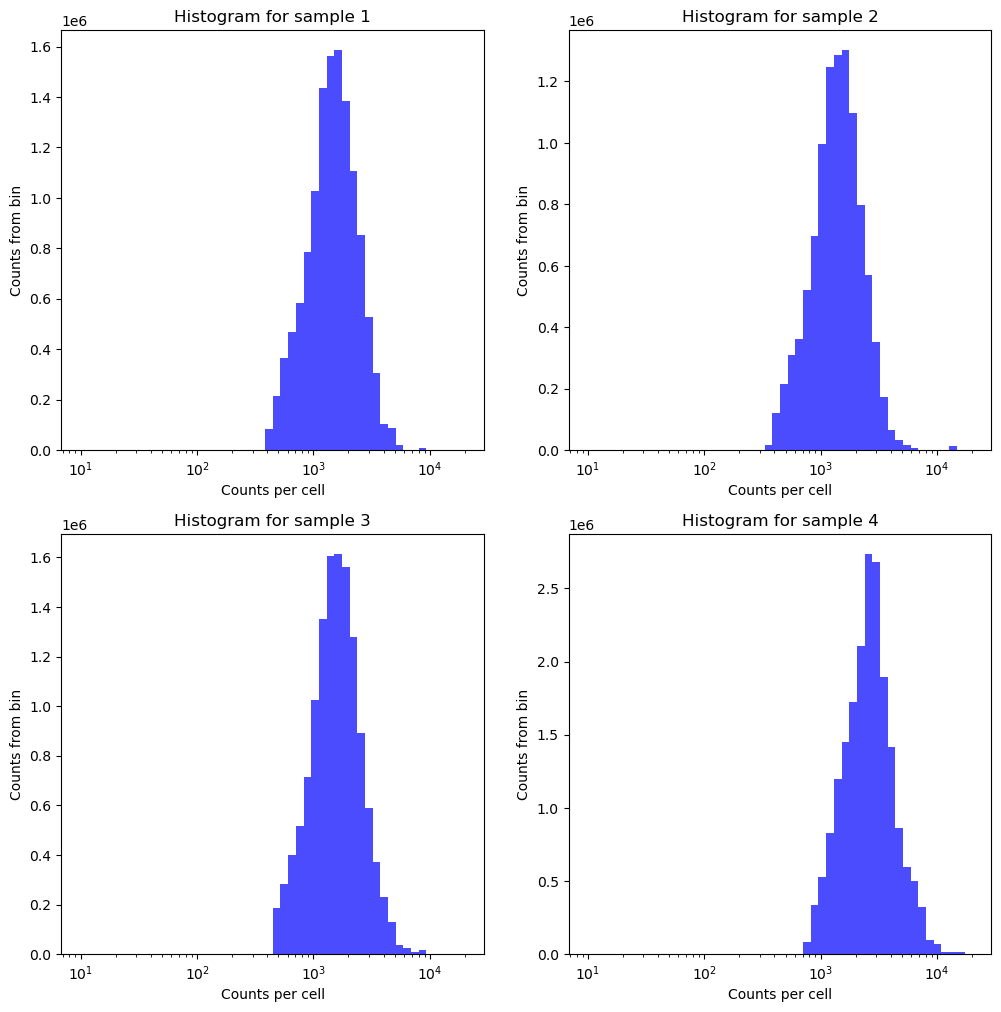

In [5]:
fig, axs = plt.subplots(2,2, figsize = (12,12))
bins = np.logspace(np.log10(10), np.log10(20000), 51)
for i,adata_raw in enumerate(adatas_raw):
    axs[i // 2][i % 2].hist(
            adata_raw.obs["total_counts"], bins=bins, weights=adata_raw.obs["total_counts"],
            color="blue", alpha=0.7
        )
    axs[i // 2][i % 2].set_xscale('log')
    axs[i // 2][i % 2].set_ylabel("Counts from bin")
    axs[i // 2][i % 2].set_xlabel("Counts per cell")
    axs[i // 2][i % 2].set_title(f"Histogram for sample {i+1}")
        
plt.show()

In [21]:
for i, adata_raw in enumerate(adatas_raw):
    n_keeps = {}
    for thr in [1, 10, 100, 200, 500, 1000, 2000, 5000, 10000]:
        n_keep = sum(adata_raw.obs['total_counts'].values>thr)
        n_keeps[thr] = n_keep
        print(f'Sample {i+1}; cells retained for min counts > {thr}: {n_keep}' )
    #print the difference between consecutive n_keeps
    for j in range(1, len(n_keeps)):
        thr_prev = list(n_keeps.keys())[j-1]
        thr_curr = list(n_keeps.keys())[j]
        diff = n_keeps[thr_prev] - n_keeps[thr_curr]
        print(f'Sample {i+1};  Difference between {thr_prev} and {thr_curr}: {diff}')

Sample 1; cells retained for min counts > 1: 9811
Sample 1; cells retained for min counts > 10: 9811
Sample 1; cells retained for min counts > 100: 9811
Sample 1; cells retained for min counts > 200: 9811
Sample 1; cells retained for min counts > 500: 9295
Sample 1; cells retained for min counts > 1000: 5881
Sample 1; cells retained for min counts > 2000: 1250
Sample 1; cells retained for min counts > 5000: 6
Sample 1; cells retained for min counts > 10000: 0
Sample 1;  Difference between 1 and 10: 0
Sample 1;  Difference between 10 and 100: 0
Sample 1;  Difference between 100 and 200: 0
Sample 1;  Difference between 200 and 500: 516
Sample 1;  Difference between 500 and 1000: 3414
Sample 1;  Difference between 1000 and 2000: 4631
Sample 1;  Difference between 2000 and 5000: 1244
Sample 1;  Difference between 5000 and 10000: 6
Sample 2; cells retained for min counts > 1: 8427
Sample 2; cells retained for min counts > 10: 8427
Sample 2; cells retained for min counts > 100: 8427
Sample 2

In [22]:
thrs = [1000, 1000, 1000, 1700]
adatas = []
for i, adata_raw in enumerate(adatas_raw):
    thr = thrs[i]
    adata = adata_raw[adata_raw.obs['total_counts'].values>thr].copy()
    adatas.append(adata)
    print(adata)

AnnData object with n_obs × n_vars = 5881 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
AnnData object with n_obs × n_vars = 4810 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
AnnData object with n_obs × n_vars = 6142 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt',

In [23]:
#filter cells with mitochondrial genes making up more than 10 percent
for i in range(len(adatas)):
    adatas[i] = adatas[i][adatas[i].obs['pct_counts_mt'] < 10].copy()
    print(adatas[i])

AnnData object with n_obs × n_vars = 5454 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
AnnData object with n_obs × n_vars = 4682 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
AnnData object with n_obs × n_vars = 5716 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt',

In [24]:
for i, adata in enumerate(adatas):
    #run scrublet to filter doublets
    sc.pp.scrublet(adata)
    cmask = adata.obs['predicted_doublet'].values == False
    adatas[i] = adata[cmask].copy()
    print(adatas[i])

AnnData object with n_obs × n_vars = 5454 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
AnnData object with n_obs × n_vars = 4679 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
AnnData object with n_obs × n_vars = 5716 × 37733
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_to

Filtering of cells is stopped here. Now perform filtering of genes.

In [25]:
#keep genes that have mean expression above 
for i, adata in enumerate(adatas):
    gmask = (adata.X > 0).sum( axis = 0) >= (adata.n_obs * 0.10)
    print(gmask.sum())
    adatas[i] = adatas[i][:, gmask].copy()
    #now also filter mitochondrial and ribosomal genes
    adatas[i] = adatas[i][:, ~(adatas[i].var['mt'] | adatas[i].var['ribo'])].copy()
    print(adatas[i]) 

1406
AnnData object with n_obs × n_vars = 5454 × 1314
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
1274
AnnData object with n_obs × n_vars = 4679 × 1181
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
1408
AnnData object with n_obs × n_vars = 5716 × 1315
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts

Now follows cell type annonation.

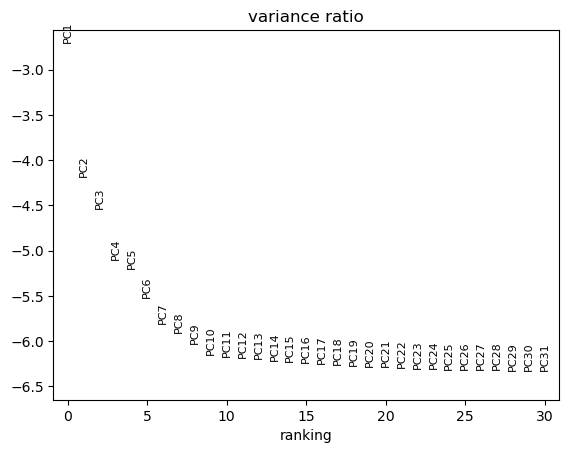

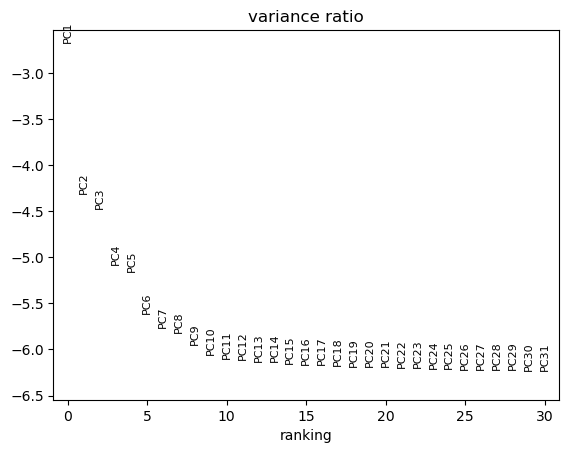

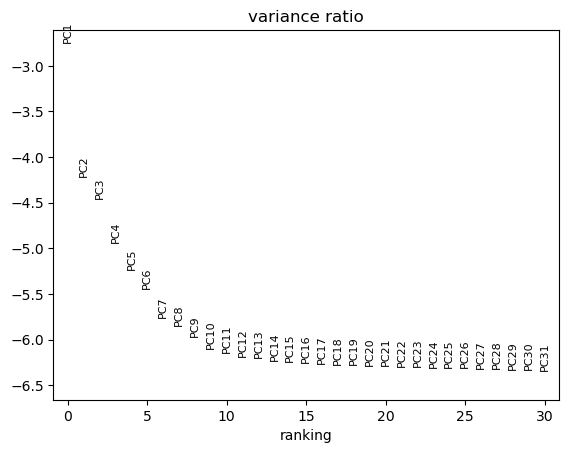

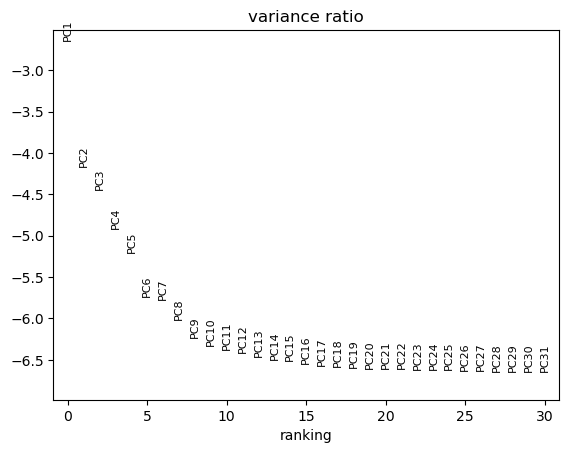

In [26]:
#annotate cells (before that save the raw counts):
#fig, axs = plt.subplots(2,2, figsize = (12,12))
for i in range(len(adatas)):
    adatas[i].layers['raw_counts'] = adatas[i].X.copy()
    sc.pp.normalize_total(adatas[i], target_sum=1e4)
    sc.pp.log1p(adatas[i])
    sc.tl.pca(adatas[i], svd_solver='arpack')
    sc.pl.pca_variance_ratio(adatas[i], log=True)



In [27]:
for i, adata in enumerate(adatas):
    sc.pp.neighbors(adata, n_pcs = 5)
    predictions_high = celltypist.annotate(adata.copy(), model='Immune_All_High.pkl', majority_voting=True)
    adatas[i] = predictions_high.to_adata()

🔬 Input data has 5454 cells and 1314 genes
🔗 Matching reference genes in the model


🧬 890 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 4679 cells and 1181 genes
🔗 Matching reference genes in the model
🧬 796 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 5716 cells and 1315 genes
🔗 Matching reference genes in the model
🧬 876 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering inpu

In [28]:
for i,adata in enumerate(adatas):
    print(f"sample {i+1} (total cells = {adata.n_obs}):")
    _ = get_label_cell_dict(adata, label_col = 'majority_voting')

sample 1 (total cells = 5454):
2694 cells are labelled as Monocytes
2143 cells are labelled as T cells
454 cells are labelled as B cells
163 cells are labelled as DC
sample 2 (total cells = 4679):
2070 cells are labelled as Monocytes
2068 cells are labelled as T cells
333 cells are labelled as B cells
135 cells are labelled as ILC
73 cells are labelled as DC
sample 3 (total cells = 5716):
2631 cells are labelled as Monocytes
2299 cells are labelled as T cells
577 cells are labelled as B cells
146 cells are labelled as ILC
63 cells are labelled as DC
sample 4 (total cells = 5287):
2554 cells are labelled as T cells
1899 cells are labelled as Monocytes
648 cells are labelled as B cells
110 cells are labelled as ILC
76 cells are labelled as DC


In [32]:
#get list of common genes:
genes = set(adatas[0].var_names)
for i in range(1, len(adatas)):
    genes = genes.intersection(set(adatas[i].var_names))
genes = sorted(list(genes))
#create a ranking of the genes based on total counts across all samples
gene_counts = {}
for gene in genes:
    gene_counts[gene] = 0
    for i in range(len(adatas)):
        counts = adatas[i][:, gene].layers['raw_counts']
        gene_counts[gene] += counts.sum()

In [33]:
gene_counts = pd.DataFrame.from_dict(gene_counts, orient='index', columns=['total_counts'])
gene_counts = gene_counts.sort_values('total_counts', ascending=False)
gene_counts['rank'] = np.arange(1, len(gene_counts) + 1)
gene_counts

,total_counts,rank
TMSB4X,912641.0,1
MALAT1,855015.0,2
B2M,614211.0,3
TMSB10,398243.0,4
FTL,375765.0,5
...,...,...
MT1X,2780.0,1112
COMMD7,2758.0,1113
ANXA7,2748.0,1114
BABAM1,2738.0,1115


In [34]:
cell_types_to_keep = ["Monocytes", "T cells", "B cells", "DC"]
#pool together by cell types
cell_type_count_matrices = {}
for cell_type in cell_types_to_keep:
    sample_counts = {}
    n_cells_dict = {}
    for i, adata in enumerate(adatas):
        adata = adata[:, genes].copy()
        cmask = adata.obs['majority_voting'] == cell_type
        adata_ct = adata[cmask].copy()
        #pool counts together by summing across cells
        counts = np.ravel(adata_ct.layers['raw_counts'].sum(axis=0))
        sample_counts[f"Sample_{i+1}"] = counts
        n_cells_dict[f"Sample_{i+1}"] = cmask.sum()
    df = pd.DataFrame(sample_counts, index=genes).T
    df['n_cells'] = pd.Series(n_cells_dict)
    cell_type_count_matrices[cell_type] = df

'''
for i, adata in enumerate(adatas.values()):
    cmask = adata.obs['predicted_labels'].isin(cell_types_to_keep)
'''

"\nfor i, adata in enumerate(adatas.values()):\n    cmask = adata.obs['predicted_labels'].isin(cell_types_to_keep)\n"

In [64]:
os.getcwd()

'/tmp/Mazutislab-out/Ignas'

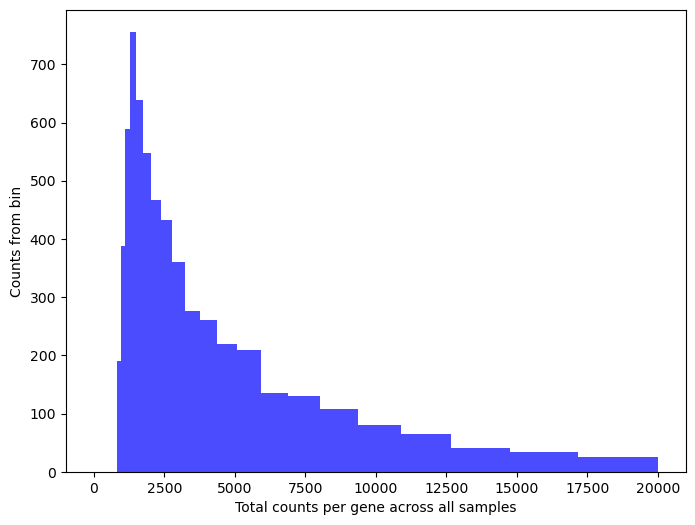

In [66]:
#get distribution of total counts for all genes across all samples
total_counts = pd.DataFrame()
for adata in adatas:
    total_counts = pd.concat([total_counts, pd.DataFrame(adata.X.sum(axis=0).T, index=adata.var_names).T], axis=0)    
#filter mitochondrial and ribosomal genes
mt_ribo_mask = ~(total_counts.columns.str.startswith('MT-') | total_counts.columns.str.startswith(('RPS', 'RPL')))
total_counts = total_counts.loc[:, mt_ribo_mask]
#plot histogram of total counts
plt.figure(figsize=(8,6))
plt.hist(
        total_counts.values.flatten(), bins=bins,
        color="blue", alpha=0.7
    )
plt.ylabel("Counts from bin")
plt.xlabel("Total counts per gene across all samples")
#get genes with total_counts < 3000
genes_medium_counts = total_counts.columns[total_counts.sum(axis=0) < 3000]
f = open("genes_medium_counts.txt", "w")
for gene in genes_medium_counts:
    f.write(f"{gene}\n")
f.close()
#genes_medium_counts.to_csv("genes_medium_counts.txt")

In [36]:
norm_cell_type_count_matrices = {}
for cell_type, df in cell_type_count_matrices.items():
    df_norm = df.div(df['n_cells'], axis=0)
    norm_cell_type_count_matrices[cell_type] = df_norm

display(cell_type_count_matrices['Monocytes']['n_cells'])
display(cell_type_count_matrices['Monocytes']['MALAT1'])

Sample_1    2694
Sample_2    2070
Sample_3    2631
Sample_4    1899
Name: n_cells, dtype: int64

Sample_1    101876.0
Sample_2     76404.0
Sample_3     32867.0
Sample_4    137014.0
Name: MALAT1, dtype: float32

In [37]:
de_results = {}
#slice_to_display = slice(1,15,1)
rank_thr = 500
fold_change_thr = 1.5
for cell_type in cell_types_to_keep:
    df = norm_cell_type_count_matrices[cell_type]
    de_result = perform_DE_test(df, group1_samples = ['Sample_1', 'Sample_2', 'Sample_3'], group2_samples = ['Sample_4'])
    de_result.set_index('feature', inplace=True)
    de_result['rank_by_total_counts'] = gene_counts['rank']
    de_result.drop(['pval', 'fdr', 'significant'], axis=1, inplace=True)
    #drop the rows where feature has rank below rank_thr in gene_counts
    de_results[cell_type] = de_result
    de_result = de_result[de_result['rank_by_total_counts'] <= rank_thr]
    de_result = de_result[de_result['Fold Change'].abs() >= fold_change_thr]
    print(f"DE results for {cell_type}:")
    display(de_results[cell_type].sort_values('Fold Change'))
    #display(de_results[cell_type].sort_values('Fold Change', ascending = False))

DE results for Monocytes:


,Fold Change,rank_by_total_counts
feature,,
TPT1,-3.888420,13.0
NEAT1,-2.764454,62.0
NAP1L1,-2.337861,125.0
IGKC,-2.189635,37.0
EEF1A1,-2.108593,8.0
...,...,...
B2M,1.191548,3.0
UBB,1.193193,46.0
POLR2L,1.205629,189.0


DE results for T cells:


,Fold Change,rank_by_total_counts
feature,,
TPT1,-7.800664,13.0
EEF1A1,-3.559129,8.0
JUNB,-3.064725,50.0
MALAT1,-3.019498,2.0
EEF2,-2.968075,146.0
...,...,...
HLA-DRA,1.217691,22.0
S100A9,1.348110,7.0
UBB,1.374882,46.0


DE results for B cells:


,Fold Change,rank_by_total_counts
feature,,
TPT1,-6.326755,13.0
EEF1A1,-3.354788,8.0
EEF2,-3.186679,146.0
CD37,-2.859738,166.0
EEF1B2,-2.766476,67.0
...,...,...
CRIP1,1.204487,40.0
UBB,1.215886,46.0
S100A8,1.334822,14.0


DE results for DC:


,Fold Change,rank_by_total_counts
feature,,
TPT1,-7.336724,13.0
ZFP36,-5.437837,176.0
EEF2,-4.214946,146.0
VIM,-4.110110,111.0
EEF1A1,-3.941623,8.0
...,...,...
ISG15,1.394982,215.0
IL32,1.405479,117.0
LTB,1.518859,45.0


In [42]:
top_up_in_maxima = pd.DataFrame()
rank_thr = 100
fold_change_thr = 1.5
for cell_type in cell_types_to_keep:
    genes_up = de_results[cell_type].sort_values(['Fold Change'], ascending = True)
    #genes_up = genes_up[(genes_up['Fold Change'] < 0) & (genes_up['Fold Change'].abs()>=fold_change_thr)]
    genes_up = genes_up[genes_up['rank_by_total_counts'] <= rank_thr]
    top_up_in_maxima[f'Fold Change in {cell_type}'] = genes_up['Fold Change']

#mask = (top_up_in_maxima < 0) & (top_up_in_maxima.abs() >= fold_change_thr)
#row_mask = mask.any(axis=1)
mask = (top_up_in_maxima < 0) & (top_up_in_maxima.abs() <= fold_change_thr)
# row_mask: True for rows where any FC column satisfies the condition
row_mask = mask.all(axis=1)

# get filtered rows
top_up_in_maxima['Rank by total counts'] = gene_counts.loc[top_up_in_maxima.index,'rank']
top_up_in_maxima = top_up_in_maxima.loc[row_mask]
display(top_up_in_maxima)
#save to csv:
top_up_in_maxima.to_csv("/tmp/Mazutislab-out/Ignas/RT_comparison/notebooks/top_up_in_maxima_no_ribo_mt.csv")

'''
row_mask = [(top_up_in_maxima.iloc[i] < 0) & (top_up_in_maxima.iloc[i].abs() >= fold_change_thr).any() for i in range(top_up_in_maxima.shape[0])]
i = len(top_up_in_maxima)-1 
print((top_up_in_maxima.iloc[i] < 0) & (top_up_in_maxima.iloc[i].abs() >= fold_change_thr).any())
display(top_up_in_maxima.iloc[row_mask])
'''

,Fold Change in Monocytes,Fold Change in T cells,Fold Change in B cells,Fold Change in DC,Rank by total counts
feature,,,,,
ATP5MC2,-1.404714,-1.307940,-1.279777,-1.393596,77
EEF1D,-1.324854,-1.360599,-1.311391,-1.466234,51
EIF4A1,-1.265481,-1.381654,-1.451350,-1.233339,96
ATP5MG,-1.186271,-1.153088,-1.145467,-1.491577,61
ARPC3,-1.185779,-1.082940,-1.130321,-1.491017,74
NFKBIA,-1.175138,-1.074336,-1.146594,-1.330344,81
TSPO,-1.171983,-1.024883,-1.027778,-1.376539,91
GMFG,-1.171242,-1.088902,-1.126291,-1.349500,84
OAZ1,-1.164831,-1.081607,-1.159116,-1.366168,31


'\nrow_mask = [(top_up_in_maxima.iloc[i] < 0) & (top_up_in_maxima.iloc[i].abs() >= fold_change_thr).any() for i in range(top_up_in_maxima.shape[0])]\ni = len(top_up_in_maxima)-1 \nprint((top_up_in_maxima.iloc[i] < 0) & (top_up_in_maxima.iloc[i].abs() >= fold_change_thr).any())\ndisplay(top_up_in_maxima.iloc[row_mask])\n'

In [20]:
os.getcwd()

'/tmp/Mazutislab-out/Ignas/RT_comparison/notebooks'

In [21]:
'''
DE_results = perform_DE_test(norm_monocyte_samples_df, ['Sample_1', 'Sample_2', 'Sample_3'], ['Sample_4'])
top_features = get_top_DE_features(DE_results, n_features_to_return = 17, ignore_p_value = True)
display(top_features)
'''

"\nDE_results = perform_DE_test(norm_monocyte_samples_df, ['Sample_1', 'Sample_2', 'Sample_3'], ['Sample_4'])\ntop_features = get_top_DE_features(DE_results, n_features_to_return = 17, ignore_p_value = True)\ndisplay(top_features)\n"